In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Per-Cow Accuracy Results

In [19]:
# Load CowBERT+POI results (best model: lr=0.005)
cowbert_acc = pd.read_csv('cowbert_out_emb16_ep500_lr0.005_withPOIs/per_cow_accuracy.csv')
cowbert_acc = cowbert_acc.rename(columns={'accuracy': 'cowbert_accuracy'})
print(f"CowBERT results loaded: {len(cowbert_acc)} cows")
print(f"Mean accuracy: {cowbert_acc['cowbert_accuracy'].mean():.2%}")
display(cowbert_acc.head())

CowBERT results loaded: 43 cows
Mean accuracy: 68.32%


,cow_id,is_poi,cowbert_accuracy,correct,total
0,3cee,False,0.820225,292,356
1,3d05,False,0.815341,287,352
2,3cfb,False,0.800866,185,231
3,3d06,False,0.794521,232,292
4,3cf1,False,0.783784,435,555


In [20]:
# Load Graph GNN results
graph_acc = pd.read_csv('graph_prediction_out/per_cow_accuracy.csv')
graph_acc = graph_acc.rename(columns={'accuracy': 'graph_accuracy'})
print(f"\nGraph GNN results loaded: {len(graph_acc)} cows")
print(f"Mean accuracy: {graph_acc['graph_accuracy'].mean():.2%}")
display(graph_acc.head())


Graph GNN results loaded: 49 cows
Mean accuracy: 75.40%


,cow_id,correct,total,graph_accuracy
0,3d09,1730,1856,0.932112
1,3668,2350,2596,0.905239
2,3cf5,1513,1700,0.890000
3,3669,1654,1929,0.857439
4,3d06,1624,1896,0.856540


In [21]:
# Merge both accuracy results
accuracy_df = cowbert_acc[['cow_id', 'cowbert_accuracy']].merge(
    graph_acc[['cow_id', 'graph_accuracy']], 
    on='cow_id', 
    how='outer'
)

print(f"\nMerged results: {len(accuracy_df)} cows")
display(accuracy_df.describe())


Merged results: 49 cows


,cowbert_accuracy,graph_accuracy
count,43.000000,49.000000
mean,0.683157,0.754039
std,0.077976,0.090975
min,0.488372,0.467940
25%,0.640078,0.707914
50%,0.700348,0.765387
75%,0.739677,0.817114
max,0.820225,0.932112


## 2. Compute Average Network Degree per Cow

In [22]:
# Load network sequences
print("Loading network sequences...")
network_file = Path('network_sequence/network_sequence_rssi-68_20251209_125949.pkl')

with open(network_file, 'rb') as f:
    data = pickle.load(f)
    # Extract graphs from list of dicts
    graphs = [item['graph'] for item in data]

print(f"Loaded {len(graphs)} graph snapshots")

# Compute average degree for each cow across all graphs
cow_degree_stats = defaultdict(list)

for G in graphs:
    for node in G.nodes():
        cow_degree_stats[node].append(G.degree(node))

# Calculate mean and std of degree for each cow
degree_data = []
for cow_id, degrees in cow_degree_stats.items():
    degree_data.append({
        'cow_id': cow_id,
        'mean_degree': np.mean(degrees),
        'std_degree': np.std(degrees),
        'max_degree': np.max(degrees),
        'min_degree': np.min(degrees),
        'num_appearances': len(degrees)
    })

degree_df = pd.DataFrame(degree_data)
print(f"\nComputed degree statistics for {len(degree_df)} cows")
display(degree_df.describe())

Loading network sequences...
Loaded 18720 graph snapshots

Computed degree statistics for 49 cows


,mean_degree,std_degree,max_degree,min_degree,num_appearances
count,49.000000,49.000000,49.000000,49.0,49.0
mean,0.732138,0.851132,5.693878,0.0,18720.0
std,0.345456,0.182684,1.140250,0.0,0.0
min,0.157425,0.384048,3.000000,0.0,18720.0
25%,0.505929,0.762883,5.000000,0.0,18720.0
50%,0.739530,0.867511,6.000000,0.0,18720.0
75%,0.866506,0.983318,6.000000,0.0,18720.0
max,2.221688,1.358182,8.000000,0.0,18720.0


In [23]:
# Merge with accuracy data
accuracy_df = accuracy_df.merge(degree_df, on='cow_id', how='left')
print(f"Merged with degree data: {len(accuracy_df)} cows")
display(accuracy_df.head(10))

Merged with degree data: 49 cows


,cow_id,cowbert_accuracy,graph_accuracy,mean_degree,std_degree,max_degree,min_degree,num_appearances
0,365d,0.546296,0.719178,0.376282,0.626834,4,0,18720
1,365e,0.650538,0.830016,0.739530,0.903990,5,0,18720
2,3660,0.702128,0.707819,0.537927,0.770346,5,0,18720
3,3662,NaN,0.817114,0.160844,0.393775,3,0,18720
4,3663,0.718045,0.758774,0.650427,0.809215,6,0,18720
5,3664,0.603015,0.793034,0.551923,0.776509,7,0,18720
6,3665,0.746324,0.832696,0.813408,0.908390,6,0,18720
7,3666,0.748485,0.749269,0.514583,0.781121,5,0,18720
8,3667,0.695652,0.722904,0.742415,0.884153,6,0,18720
9,3668,NaN,0.905239,1.127724,1.005530,6,0,18720


## 3. Load and Process Accelerometry Data

In [24]:
# Load accelerometry data for all cows
accel_dir = Path('data/Accelerometer')
accel_files = sorted(accel_dir.glob('*_accel_elevage_3_cut.parquet'))

print(f"Found {len(accel_files)} accelerometry files")

accel_stats = []

for file in accel_files:
    # Extract cow ID from filename (e.g., '365d_accel_elevage_3_cut.parquet' -> '365d')
    cow_id = file.stem.split('_')[0]
    
    try:
        # Load accelerometry data
        df_accel = pd.read_parquet(file)
        
        # Compute norm of acceleration (activity level)
        if all(col in df_accel.columns for col in ['acc_x', 'acc_y', 'acc_z']):
            df_accel['norm'] = np.sqrt(df_accel['acc_x']**2 + df_accel['acc_y']**2 + df_accel['acc_z']**2)
            
            accel_stats.append({
                'cow_id': cow_id,
                'mean_accel_norm': df_accel['norm'].mean(),
                'std_accel_norm': df_accel['norm'].std(),
                'max_accel_norm': df_accel['norm'].max(),
                'median_accel_norm': df_accel['norm'].median(),
                'num_accel_samples': len(df_accel)
            })
    except Exception as e:
        print(f"Error processing {file.name}: {e}")

accel_df = pd.DataFrame(accel_stats)
print(f"\nProcessed accelerometry data for {len(accel_df)} cows")
if len(accel_df) > 0:
    display(accel_df.describe())

Found 47 accelerometry files

Processed accelerometry data for 47 cows


,mean_accel_norm,std_accel_norm,max_accel_norm,median_accel_norm,num_accel_samples
count,47.000000,47.000000,47.000000,47.000000,4.700000e+01
mean,0.963135,0.032964,2.492674,0.960945,9.676790e+06
std,0.024818,0.008849,0.223662,0.027493,1.458650e-01
min,0.923507,0.007204,1.791179,0.917515,9.676789e+06
25%,0.948361,0.030375,2.382852,0.943097,9.676790e+06
50%,0.960131,0.035043,2.520636,0.958527,9.676790e+06
75%,0.971518,0.037320,2.649431,0.971471,9.676790e+06
max,1.032701,0.054697,2.852149,1.037346,9.676790e+06


In [25]:
# Merge with accuracy and degree data
final_df = accuracy_df.merge(accel_df, on='cow_id', how='left')
print(f"Final merged dataset: {len(final_df)} cows")
print(f"Cows with complete data: {final_df.dropna().shape[0]}")
display(final_df.head(10))

Final merged dataset: 49 cows
Cows with complete data: 41


,cow_id,cowbert_accuracy,graph_accuracy,mean_degree,std_degree,max_degree,min_degree,num_appearances,mean_accel_norm,std_accel_norm,max_accel_norm,median_accel_norm,num_accel_samples
0,365d,0.546296,0.719178,0.376282,0.626834,4,0,18720,0.951888,0.029211,2.334055,0.946069,9676790.0
1,365e,0.650538,0.830016,0.739530,0.903990,5,0,18720,0.958042,0.035283,2.826667,0.951743,9676790.0
2,3660,0.702128,0.707819,0.537927,0.770346,5,0,18720,0.952272,0.037989,2.496665,0.945503,9676790.0
3,3662,NaN,0.817114,0.160844,0.393775,3,0,18720,0.999213,0.007204,1.791179,0.999769,9676790.0
4,3663,0.718045,0.758774,0.650427,0.809215,6,0,18720,0.963426,0.030109,2.492602,0.962963,9676790.0
5,3664,0.603015,0.793034,0.551923,0.776509,7,0,18720,0.966940,0.037396,2.370729,0.967931,9676790.0
6,3665,0.746324,0.832696,0.813408,0.908390,6,0,18720,0.930633,0.043637,2.650788,0.926076,9676790.0
7,3666,0.748485,0.749269,0.514583,0.781121,5,0,18720,0.948601,0.032569,2.727474,0.947772,9676790.0
8,3667,0.695652,0.722904,0.742415,0.884153,6,0,18720,0.946607,0.033215,2.676120,0.945741,9676790.0
9,3668,NaN,0.905239,1.127724,1.005530,6,0,18720,0.958032,0.035573,1.964338,0.942391,9676790.0


In [26]:
# Save the merged dataset
final_df.to_csv('cow_accuracy_analysis.csv', index=False)
print("Saved merged dataset to 'cow_accuracy_analysis.csv'")

Saved merged dataset to 'cow_accuracy_analysis.csv'


## 4. Statistical Analysis: Correlations

In [27]:
# Compute correlations (only for cows with complete data)
complete_df = final_df.dropna()
print(f"Analyzing {len(complete_df)} cows with complete data\n")

# Variables to correlate
variables = ['cowbert_accuracy', 'graph_accuracy', 'mean_degree', 'mean_accel_norm']

# Correlation matrix
corr_matrix = complete_df[variables].corr()

print("Pearson Correlation Matrix:")
display(corr_matrix)

# Compute p-values
print("\nDetailed Correlations (Pearson):")
for i, var1 in enumerate(variables):
    for var2 in variables[i+1:]:
        r, p = pearsonr(complete_df[var1], complete_df[var2])
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        print(f"{var1:20s} vs {var2:20s}: r={r:+.3f}, p={p:.4f} {sig}")

Analyzing 41 cows with complete data

Pearson Correlation Matrix:


,cowbert_accuracy,graph_accuracy,mean_degree,mean_accel_norm
cowbert_accuracy,1.000000,-0.124165,0.437255,0.061948
graph_accuracy,-0.124165,1.000000,0.035126,-0.465715
mean_degree,0.437255,0.035126,1.000000,0.011772
mean_accel_norm,0.061948,-0.465715,0.011772,1.000000



Detailed Correlations (Pearson):
cowbert_accuracy     vs graph_accuracy      : r=-0.124, p=0.4393 ns
cowbert_accuracy     vs mean_degree         : r=+0.437, p=0.0043 **
cowbert_accuracy     vs mean_accel_norm     : r=+0.062, p=0.7004 ns
graph_accuracy       vs mean_degree         : r=+0.035, p=0.8274 ns
graph_accuracy       vs mean_accel_norm     : r=-0.466, p=0.0022 **
mean_degree          vs mean_accel_norm     : r=+0.012, p=0.9418 ns


In [28]:
# Spearman correlation (for non-linear relationships)
print("\nSpearman Correlations (rank-based):")
for i, var1 in enumerate(variables):
    for var2 in variables[i+1:]:
        rho, p = spearmanr(complete_df[var1], complete_df[var2])
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        print(f"{var1:20s} vs {var2:20s}: ρ={rho:+.3f}, p={p:.4f} {sig}")


Spearman Correlations (rank-based):
cowbert_accuracy     vs graph_accuracy      : ρ=-0.031, p=0.8465 ns
cowbert_accuracy     vs mean_degree         : ρ=+0.374, p=0.0161 *
cowbert_accuracy     vs mean_accel_norm     : ρ=+0.064, p=0.6929 ns
graph_accuracy       vs mean_degree         : ρ=+0.025, p=0.8754 ns
graph_accuracy       vs mean_accel_norm     : ρ=-0.339, p=0.0302 *
mean_degree          vs mean_accel_norm     : ρ=-0.006, p=0.9681 ns


## 5. Visualizations

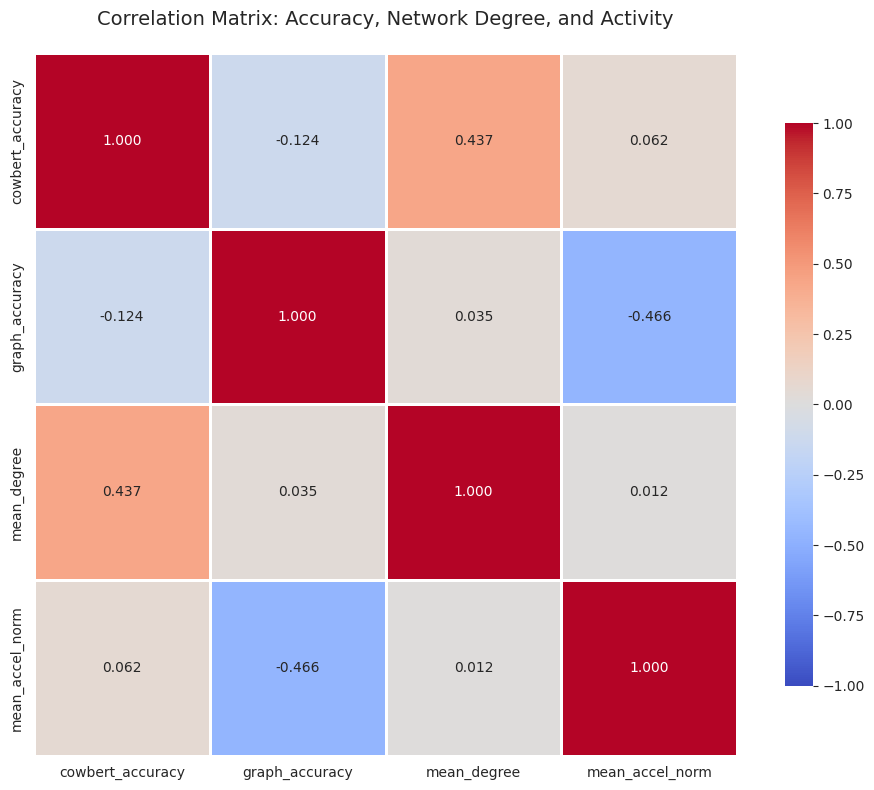

In [29]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Accuracy, Network Degree, and Activity', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

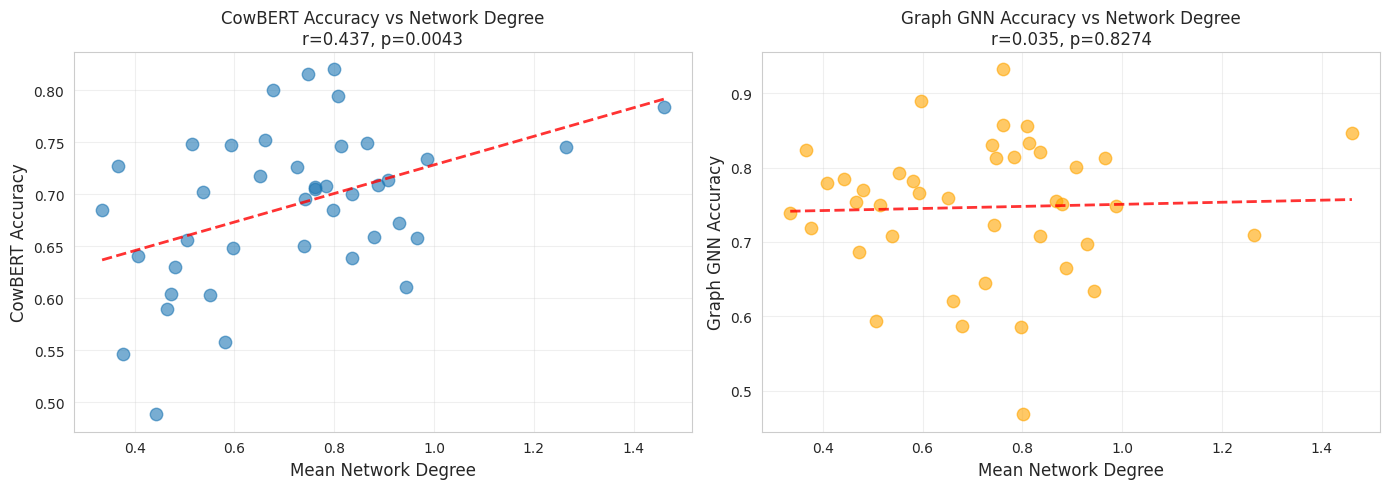

In [30]:
# Scatter plots: Accuracy vs Mean Degree
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CowBERT accuracy vs degree
ax = axes[0]
ax.scatter(complete_df['mean_degree'], complete_df['cowbert_accuracy'], alpha=0.6, s=80)
z = np.polyfit(complete_df['mean_degree'], complete_df['cowbert_accuracy'], 1)
p = np.poly1d(z)
ax.plot(complete_df['mean_degree'].sort_values(), p(complete_df['mean_degree'].sort_values()), 
        "r--", alpha=0.8, linewidth=2)
r, pval = pearsonr(complete_df['mean_degree'], complete_df['cowbert_accuracy'])
ax.set_xlabel('Mean Network Degree', fontsize=12)
ax.set_ylabel('CowBERT Accuracy', fontsize=12)
ax.set_title(f'CowBERT Accuracy vs Network Degree\nr={r:.3f}, p={pval:.4f}', fontsize=12)
ax.grid(True, alpha=0.3)

# Graph GNN accuracy vs degree
ax = axes[1]
ax.scatter(complete_df['mean_degree'], complete_df['graph_accuracy'], alpha=0.6, s=80, color='orange')
z = np.polyfit(complete_df['mean_degree'], complete_df['graph_accuracy'], 1)
p = np.poly1d(z)
ax.plot(complete_df['mean_degree'].sort_values(), p(complete_df['mean_degree'].sort_values()), 
        "r--", alpha=0.8, linewidth=2)
r, pval = pearsonr(complete_df['mean_degree'], complete_df['graph_accuracy'])
ax.set_xlabel('Mean Network Degree', fontsize=12)
ax.set_ylabel('Graph GNN Accuracy', fontsize=12)
ax.set_title(f'Graph GNN Accuracy vs Network Degree\nr={r:.3f}, p={pval:.4f}', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('accuracy_vs_degree.png', dpi=300, bbox_inches='tight')
plt.show()

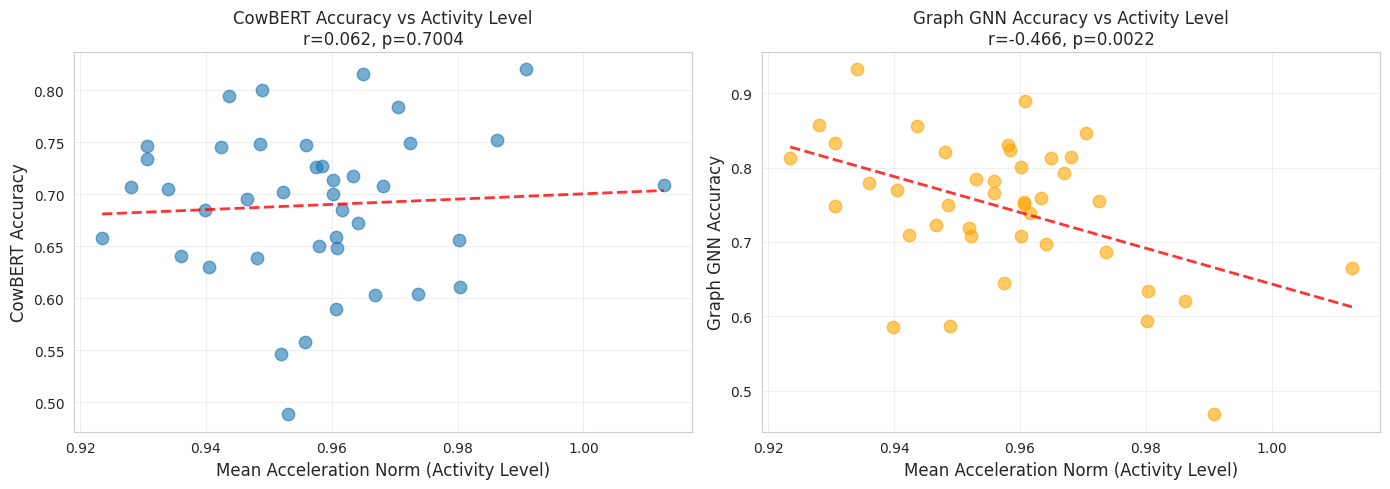

In [31]:
# Scatter plots: Accuracy vs Accelerometry
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CowBERT accuracy vs activity
ax = axes[0]
ax.scatter(complete_df['mean_accel_norm'], complete_df['cowbert_accuracy'], alpha=0.6, s=80)
z = np.polyfit(complete_df['mean_accel_norm'], complete_df['cowbert_accuracy'], 1)
p = np.poly1d(z)
ax.plot(complete_df['mean_accel_norm'].sort_values(), p(complete_df['mean_accel_norm'].sort_values()), 
        "r--", alpha=0.8, linewidth=2)
r, pval = pearsonr(complete_df['mean_accel_norm'], complete_df['cowbert_accuracy'])
ax.set_xlabel('Mean Acceleration Norm (Activity Level)', fontsize=12)
ax.set_ylabel('CowBERT Accuracy', fontsize=12)
ax.set_title(f'CowBERT Accuracy vs Activity Level\nr={r:.3f}, p={pval:.4f}', fontsize=12)
ax.grid(True, alpha=0.3)

# Graph GNN accuracy vs activity
ax = axes[1]
ax.scatter(complete_df['mean_accel_norm'], complete_df['graph_accuracy'], alpha=0.6, s=80, color='orange')
z = np.polyfit(complete_df['mean_accel_norm'], complete_df['graph_accuracy'], 1)
p = np.poly1d(z)
ax.plot(complete_df['mean_accel_norm'].sort_values(), p(complete_df['mean_accel_norm'].sort_values()), 
        "r--", alpha=0.8, linewidth=2)
r, pval = pearsonr(complete_df['mean_accel_norm'], complete_df['graph_accuracy'])
ax.set_xlabel('Mean Acceleration Norm (Activity Level)', fontsize=12)
ax.set_ylabel('Graph GNN Accuracy', fontsize=12)
ax.set_title(f'Graph GNN Accuracy vs Activity Level\nr={r:.3f}, p={pval:.4f}', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('accuracy_vs_activity.png', dpi=300, bbox_inches='tight')
plt.show()

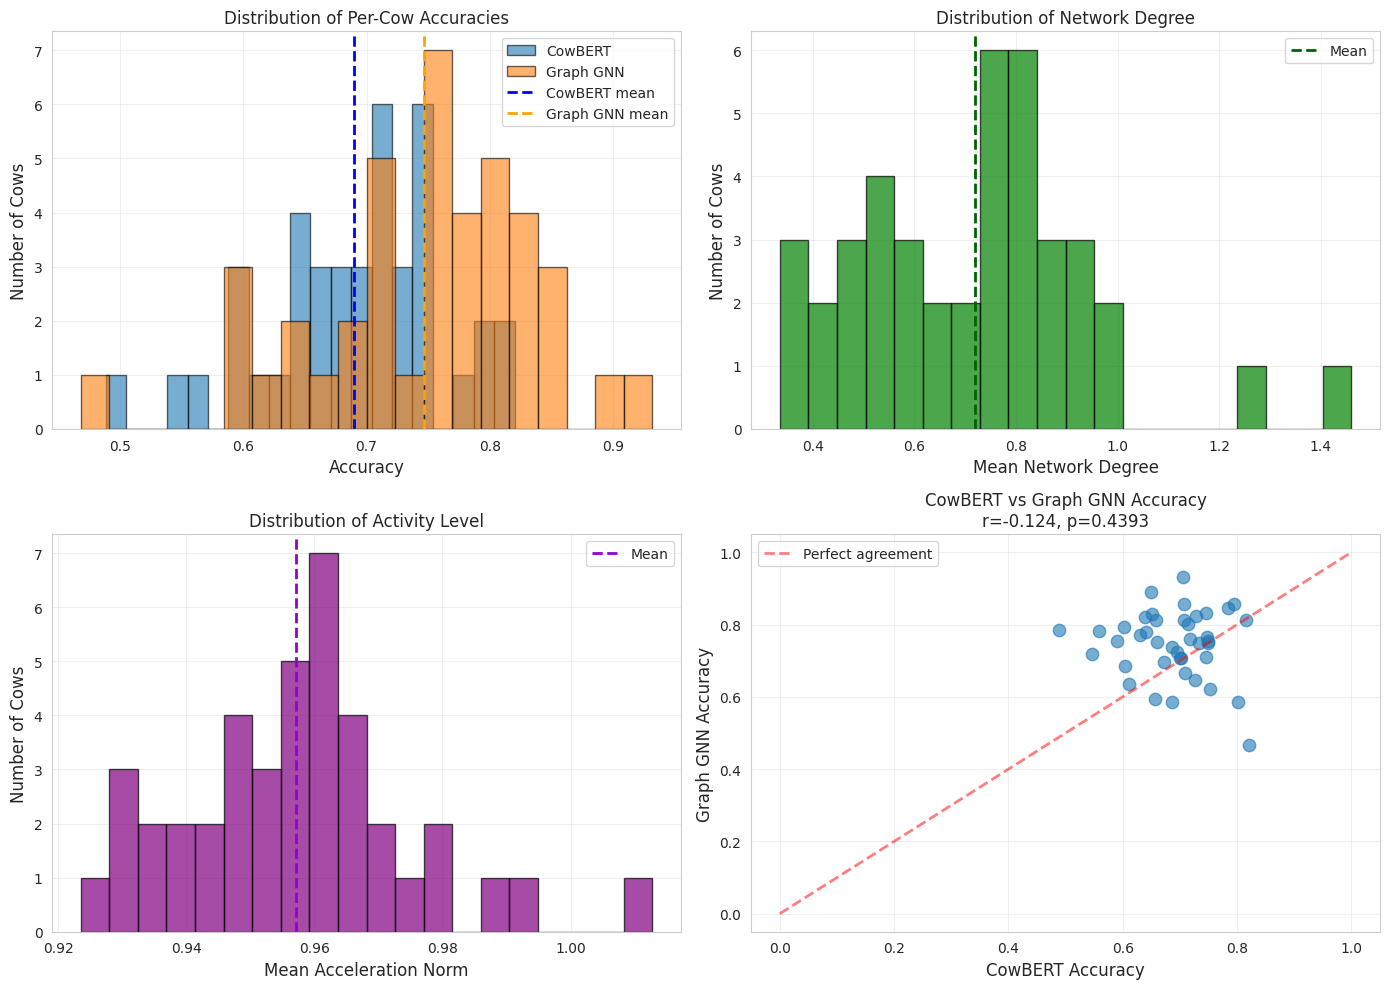

In [32]:
# Distribution comparisons
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy distributions
ax = axes[0, 0]
ax.hist(complete_df['cowbert_accuracy'], bins=20, alpha=0.6, label='CowBERT', edgecolor='black')
ax.hist(complete_df['graph_accuracy'], bins=20, alpha=0.6, label='Graph GNN', edgecolor='black')
ax.axvline(complete_df['cowbert_accuracy'].mean(), color='blue', linestyle='--', linewidth=2, label='CowBERT mean')
ax.axvline(complete_df['graph_accuracy'].mean(), color='orange', linestyle='--', linewidth=2, label='Graph GNN mean')
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Number of Cows', fontsize=12)
ax.set_title('Distribution of Per-Cow Accuracies', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Degree distribution
ax = axes[0, 1]
ax.hist(complete_df['mean_degree'], bins=20, alpha=0.7, edgecolor='black', color='green')
ax.axvline(complete_df['mean_degree'].mean(), color='darkgreen', linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Mean Network Degree', fontsize=12)
ax.set_ylabel('Number of Cows', fontsize=12)
ax.set_title('Distribution of Network Degree', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Activity distribution
ax = axes[1, 0]
ax.hist(complete_df['mean_accel_norm'], bins=20, alpha=0.7, edgecolor='black', color='purple')
ax.axvline(complete_df['mean_accel_norm'].mean(), color='darkviolet', linestyle='--', linewidth=2, label='Mean')
ax.set_xlabel('Mean Acceleration Norm', fontsize=12)
ax.set_ylabel('Number of Cows', fontsize=12)
ax.set_title('Distribution of Activity Level', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# CowBERT vs Graph GNN accuracy
ax = axes[1, 1]
ax.scatter(complete_df['cowbert_accuracy'], complete_df['graph_accuracy'], alpha=0.6, s=80)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, linewidth=2, label='Perfect agreement')
r, pval = pearsonr(complete_df['cowbert_accuracy'], complete_df['graph_accuracy'])
ax.set_xlabel('CowBERT Accuracy', fontsize=12)
ax.set_ylabel('Graph GNN Accuracy', fontsize=12)
ax.set_title(f'CowBERT vs Graph GNN Accuracy\nr={r:.3f}, p={pval:.4f}', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distributions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Identify Interesting Cases

In [33]:
# High degree, high accuracy
print("=" * 70)
print("HIGH DEGREE + HIGH ACCURACY (Social and Predictable)")
print("=" * 70)
high_both = complete_df[
    (complete_df['mean_degree'] > complete_df['mean_degree'].quantile(0.75)) &
    (complete_df['graph_accuracy'] > complete_df['graph_accuracy'].quantile(0.75))
].sort_values('graph_accuracy', ascending=False)
display(high_both[['cow_id', 'cowbert_accuracy', 'graph_accuracy', 'mean_degree', 'mean_accel_norm']].head(10))

HIGH DEGREE + HIGH ACCURACY (Social and Predictable)


,cow_id,cowbert_accuracy,graph_accuracy,mean_degree,mean_accel_norm
23,3cf1,0.783784,0.847047,1.46031,0.970531


In [34]:
# Low degree, low accuracy
print("\n" + "=" * 70)
print("LOW DEGREE + LOW ACCURACY (Isolated and Unpredictable)")
print("=" * 70)
low_both = complete_df[
    (complete_df['mean_degree'] < complete_df['mean_degree'].quantile(0.25)) &
    (complete_df['graph_accuracy'] < complete_df['graph_accuracy'].quantile(0.25))
].sort_values('graph_accuracy')
display(low_both[['cow_id', 'cowbert_accuracy', 'graph_accuracy', 'mean_degree', 'mean_accel_norm']].head(10))


LOW DEGREE + LOW ACCURACY (Isolated and Unpredictable)


,cow_id,cowbert_accuracy,graph_accuracy,mean_degree,mean_accel_norm
31,3cf9,0.656000,0.593836,0.505929,0.980251
21,3cef,0.604167,0.686275,0.472009,0.973712


In [35]:
# High activity, high accuracy
print("\n" + "=" * 70)
print("HIGH ACTIVITY + HIGH ACCURACY (Active and Predictable)")
print("=" * 70)
high_activity_acc = complete_df[
    (complete_df['mean_accel_norm'] > complete_df['mean_accel_norm'].quantile(0.75)) &
    (complete_df['cowbert_accuracy'] > complete_df['cowbert_accuracy'].quantile(0.75))
].sort_values('cowbert_accuracy', ascending=False)
display(high_activity_acc[['cow_id', 'cowbert_accuracy', 'graph_accuracy', 'mean_degree', 'mean_accel_norm']].head(10))


HIGH ACTIVITY + HIGH ACCURACY (Active and Predictable)


,cow_id,cowbert_accuracy,graph_accuracy,mean_degree,mean_accel_norm
20,3cee,0.820225,0.467940,0.800321,0.990830
23,3cf1,0.783784,0.847047,1.460310,0.970531
38,3d01,0.752033,0.621111,0.661752,0.986210
34,3cfc,0.749104,0.755501,0.866506,0.972504


In [36]:
# Graph GNN better than CowBERT
print("\n" + "=" * 70)
print("GRAPH GNN >> COWBERT (Spatial structure more distinctive than temporal)")
print("=" * 70)
complete_df['accuracy_diff'] = complete_df['graph_accuracy'] - complete_df['cowbert_accuracy']
graph_better = complete_df.nlargest(10, 'accuracy_diff')
display(graph_better[['cow_id', 'cowbert_accuracy', 'graph_accuracy', 'accuracy_diff', 'mean_degree', 'mean_accel_norm']])


GRAPH GNN >> COWBERT (Spatial structure more distinctive than temporal)


/tmp/ipykernel_3723247/3227247139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df['accuracy_diff'] = complete_df['graph_accuracy'] - complete_df['cowbert_accuracy']


,cow_id,cowbert_accuracy,graph_accuracy,accuracy_diff,mean_degree,mean_accel_norm
25,3cf3,0.488372,0.784858,0.296485,0.442575,0.953098
27,3cf5,0.648536,0.890000,0.241464,0.597489,0.960843
46,3d09,0.705628,0.932112,0.226484,0.760897,0.934052
44,3d07,0.558511,0.782027,0.223516,0.581250,0.955813
5,3664,0.603015,0.793034,0.190019,0.551923,0.966940
47,3d0c,0.639130,0.820636,0.181506,0.834776,0.948121
1,365e,0.650538,0.830016,0.179479,0.739530,0.958042
0,365d,0.546296,0.719178,0.172882,0.376282,0.951888
40,3d03,0.589744,0.754231,0.164487,0.465812,0.960617
17,3ceb,0.657993,0.812637,0.154645,0.964904,0.923507


In [37]:
# CowBERT better than Graph GNN
print("\n" + "=" * 70)
print("COWBERT >> GRAPH GNN (Temporal patterns more distinctive than spatial)")
print("=" * 70)
cowbert_better = complete_df.nsmallest(10, 'accuracy_diff')
display(cowbert_better[['cow_id', 'cowbert_accuracy', 'graph_accuracy', 'accuracy_diff', 'mean_degree', 'mean_accel_norm']])


COWBERT >> GRAPH GNN (Temporal patterns more distinctive than spatial)


,cow_id,cowbert_accuracy,graph_accuracy,accuracy_diff,mean_degree,mean_accel_norm
20,3cee,0.820225,0.467940,-0.352285,0.800321,0.990830
33,3cfb,0.800866,0.586772,-0.214094,0.678098,0.948874
38,3d01,0.752033,0.621111,-0.130921,0.661752,0.986210
37,3cff,0.685259,0.585171,-0.100088,0.797650,0.939845
45,3d08,0.726141,0.645277,-0.080864,0.725748,0.957497
31,3cf9,0.656000,0.593836,-0.062164,0.505929,0.980251
36,3cfe,0.709343,0.665372,-0.043971,0.887821,1.012776
30,3cf8,0.745380,0.709515,-0.035865,1.263622,0.942428
42,3d05,0.815341,0.813181,-0.002160,0.747276,0.964971
7,3666,0.748485,0.749269,0.000784,0.514583,0.948601


## 7. Summary Statistics and Insights

In [38]:
print("=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"\nTotal cows analyzed: {len(complete_df)}")
print(f"\nAccuracy:")
print(f"  CowBERT:   {complete_df['cowbert_accuracy'].mean():.2%} ± {complete_df['cowbert_accuracy'].std():.2%}")
print(f"  Graph GNN: {complete_df['graph_accuracy'].mean():.2%} ± {complete_df['graph_accuracy'].std():.2%}")
print(f"\nNetwork Degree:")
print(f"  Mean: {complete_df['mean_degree'].mean():.2f} ± {complete_df['mean_degree'].std():.2f}")
print(f"  Range: [{complete_df['mean_degree'].min():.2f}, {complete_df['mean_degree'].max():.2f}]")
print(f"\nActivity Level (Acceleration Norm):")
print(f"  Mean: {complete_df['mean_accel_norm'].mean():.2f} ± {complete_df['mean_accel_norm'].std():.2f}")
print(f"  Range: [{complete_df['mean_accel_norm'].min():.2f}, {complete_df['mean_accel_norm'].max():.2f}]")
print(f"\nModel Comparison:")
print(f"  Graph GNN better: {(complete_df['accuracy_diff'] > 0).sum()} cows ({(complete_df['accuracy_diff'] > 0).mean():.1%})")
print(f"  CowBERT better: {(complete_df['accuracy_diff'] < 0).sum()} cows ({(complete_df['accuracy_diff'] < 0).mean():.1%})")
print(f"  Mean difference: {complete_df['accuracy_diff'].mean():.2%} (Graph GNN - CowBERT)")

SUMMARY STATISTICS

Total cows analyzed: 41

Accuracy:
  CowBERT:   68.97% ± 7.38%
  Graph GNN: 74.67% ± 9.33%

Network Degree:
  Mean: 0.72 ± 0.23
  Range: [0.33, 1.46]

Activity Level (Acceleration Norm):
  Mean: 0.96 ± 0.02
  Range: [0.92, 1.01]

Model Comparison:
  Graph GNN better: 32 cows (78.0%)
  CowBERT better: 9 cows (22.0%)
  Mean difference: 5.70% (Graph GNN - CowBERT)


In [39]:
# Key insights
print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)

r_degree_graph, p_degree_graph = pearsonr(complete_df['mean_degree'], complete_df['graph_accuracy'])
r_degree_cowbert, p_degree_cowbert = pearsonr(complete_df['mean_degree'], complete_df['cowbert_accuracy'])
r_activity_cowbert, p_activity_cowbert = pearsonr(complete_df['mean_accel_norm'], complete_df['cowbert_accuracy'])
r_activity_graph, p_activity_graph = pearsonr(complete_df['mean_accel_norm'], complete_df['graph_accuracy'])

print(f"\n1. NETWORK DEGREE and PREDICTION ACCURACY:")
if abs(r_degree_graph) > 0.3 and p_degree_graph < 0.05:
    direction = "positive" if r_degree_graph > 0 else "negative"
    print(f"   ✓ {direction.upper()} correlation for Graph GNN (r={r_degree_graph:.3f}, p={p_degree_graph:.4f})")
    if r_degree_graph > 0:
        print(f"     → Cows with more connections are easier to identify spatially")
    else:
        print(f"     → Isolated cows are easier to identify spatially")
else:
    print(f"   ✗ No strong correlation for Graph GNN (r={r_degree_graph:.3f}, p={p_degree_graph:.4f})")

if abs(r_degree_cowbert) > 0.3 and p_degree_cowbert < 0.05:
    direction = "positive" if r_degree_cowbert > 0 else "negative"
    print(f"   ✓ {direction.upper()} correlation for CowBERT (r={r_degree_cowbert:.3f}, p={p_degree_cowbert:.4f})")
else:
    print(f"   ✗ No strong correlation for CowBERT (r={r_degree_cowbert:.3f}, p={p_degree_cowbert:.4f})")

print(f"\n2. ACTIVITY LEVEL and PREDICTION ACCURACY:")
if abs(r_activity_cowbert) > 0.3 and p_activity_cowbert < 0.05:
    direction = "positive" if r_activity_cowbert > 0 else "negative"
    print(f"   ✓ {direction.upper()} correlation for CowBERT (r={r_activity_cowbert:.3f}, p={p_activity_cowbert:.4f})")
    if r_activity_cowbert > 0:
        print(f"     → More active cows have more distinctive movement patterns")
    else:
        print(f"     → Less active cows have more predictable routines")
else:
    print(f"   ✗ No strong correlation for CowBERT (r={r_activity_cowbert:.3f}, p={p_activity_cowbert:.4f})")

if abs(r_activity_graph) > 0.3 and p_activity_graph < 0.05:
    direction = "positive" if r_activity_graph > 0 else "negative"
    print(f"   ✓ {direction.upper()} correlation for Graph GNN (r={r_activity_graph:.3f}, p={p_activity_graph:.4f})")
else:
    print(f"   ✗ No strong correlation for Graph GNN (r={r_activity_graph:.3f}, p={p_activity_graph:.4f})")

print(f"\n3. MODEL COMPARISON:")
if complete_df['graph_accuracy'].mean() > complete_df['cowbert_accuracy'].mean():
    diff_pct = (complete_df['graph_accuracy'].mean() - complete_df['cowbert_accuracy'].mean()) * 100
    print(f"   ✓ Graph GNN outperforms CowBERT by {diff_pct:.1f} percentage points")
    print(f"     → Spatial network structure is more distinctive than temporal patterns")
else:
    diff_pct = (complete_df['cowbert_accuracy'].mean() - complete_df['graph_accuracy'].mean()) * 100
    print(f"   ✓ CowBERT outperforms Graph GNN by {diff_pct:.1f} percentage points")
    print(f"     → Temporal movement patterns are more distinctive than spatial structure")

print("\n" + "=" * 70)


KEY INSIGHTS

1. NETWORK DEGREE and PREDICTION ACCURACY:
   ✗ No strong correlation for Graph GNN (r=0.035, p=0.8274)
   ✓ POSITIVE correlation for CowBERT (r=0.437, p=0.0043)

2. ACTIVITY LEVEL and PREDICTION ACCURACY:
   ✗ No strong correlation for CowBERT (r=0.062, p=0.7004)
   ✓ NEGATIVE correlation for Graph GNN (r=-0.466, p=0.0022)

3. MODEL COMPARISON:
   ✓ Graph GNN outperforms CowBERT by 5.7 percentage points
     → Spatial network structure is more distinctive than temporal patterns

